# Exploring the New Sample Dataset

**Goal**: Test the weighting and hard cut config of the data loading process

In [1]:
%load_ext autoreload
%autoreload 2

import os
import yaml
import logging

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from itertools import chain
import seaborn as sns

logging.basicConfig(level=logging.INFO)

/global/homes/d/danieltm/.conda/envs/gnn4itk/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Study Raw File Processing

In [2]:
config_file = "athena_reader_config.yaml"
config = yaml.load(open(config_file, "r"), Loader=yaml.FullLoader)

In [3]:
from gnn4itk_cf.stages.data_reading.models.athena_reader import AthenaReader
from gnn4itk_cf.stages.data_reading.models import athena_utils

INFO:root:Wandb found, using WandbLogger


In [4]:
reader = AthenaReader(config_file)

In [5]:
event = reader.trainset[0]

In [23]:
reader.trainset[0]

{'event_id': '752',
 'clusters': '/global/cfs/cdirs/m3443/data/ITk-upgrade/processed_2023paper/ttbar_correlated/all_events/clusters_evt752.txt',
 'particles': '/global/cfs/cdirs/m3443/data/ITk-upgrade/processed_2023paper/ttbar_correlated/all_events/particles_evt752.txt',
 'spacepoints': '/global/cfs/cdirs/m3443/data/ITk-upgrade/processed_2023paper/ttbar_correlated/all_events/spacepoints_evt752.txt'}

In [6]:
clusters_file = event["clusters"]
particles_file = event["particles"]
spacepoints_file = event["spacepoints"]
event_id = event["event_id"]

In [7]:
particles = athena_utils.read_particles(particles_file)
particles = athena_utils.convert_barcodes(particles)
particles = particles.astype(reader.config["particles_datatypes"])

In [8]:
pixel_spacepoints, strip_spacepoints = athena_utils.read_spacepoints(spacepoints_file)

In [9]:
pixel_spacepoints

,hit_id,x,y,z,cluster_index_1,cluster_index_2
0,0,-33.2500,0.275,-265.0,0,NaN
1,1,-33.7250,9.175,-265.0,1,NaN
2,2,-34.2188,5.375,-265.0,2,NaN
3,3,-34.5500,-8.175,-265.0,3,NaN
4,4,-34.7000,1.225,-265.0,4,NaN
...,...,...,...,...,...,...
247057,247057,31.1073,302.229,2847.5,247057,NaN
247058,247058,32.5315,307.778,2847.5,247058,NaN
247059,247059,18.4437,311.800,2847.5,247059,NaN
247060,247060,44.3163,311.253,2847.5,247060,NaN


In [10]:
strip_spacepoints

,hit_id,x,y,z,cluster_index_1,cluster_index_2
247062,247062,-400.837,27.36130,-1501.25,247062,247110.0
247063,247063,-389.169,6.07060,-1501.25,247066,247101.0
247064,247064,-384.427,-7.48776,-1501.25,247068,247100.0
247065,247065,-393.142,-21.72120,-1501.25,247070,247099.0
247066,247066,-402.980,27.92850,-1501.25,247071,247110.0
...,...,...,...,...,...,...
329011,329011,899.648,-120.05400,2854.25,462503,462513.0
329012,329012,956.186,-134.29600,2854.25,462504,462511.0
329013,329013,898.954,-125.14400,2854.25,462504,462512.0
329014,329014,898.153,-130.76900,2854.25,462505,462510.0


In [11]:
column_sets = ["coordinates", "region", "barcodes", "cells", "shape", "norms", "covariance"]

clusters_raw = pd.read_csv(clusters_file, header=None, sep=r",#,|#,|,#", engine='python')
clusters_raw.columns = column_sets

In [27]:
# check if "STRIP" is in each row of clusters_raw.coordinates
STRIP_rows = clusters_raw.coordinates.str.contains("STRIP")

In [31]:
clusters_raw[STRIP_rows].barcodes.isna().sum()

215452

In [14]:
clusters_processed, shape_list = athena_utils.split_cluster_entries(clusters_raw, particles, reader.config["column_lookup"])

In [17]:
clusters_processed[clusters_processed.hardware == "STRIP"]

,cluster_id,hardware,cluster_x,cluster_y,cluster_z,barrel_endcap,layer_disk,eta_module,phi_module,side,...,localDir1,localDir2,lengthDir0,lengthDir1,lengthDir2,glob_eta,glob_phi,eta_angle,phi_angle,particle_id
247062,247063,STRIP,-393.067,26.9644,-1501.25,-2,0,0,0,0,...,0.303351,0.32,-18.9653,0.879664,0,0.0123086,-1.58597,0.8121,0.0123092,NaN
247063,247064,STRIP,-393.53,19.0358,-1501.25,-2,0,0,0,0,...,0.0758779,0.32,-18.9793,0.495006,0,0.0123165,-1.57722,1.33798,0.0123162,NaN
247064,247065,STRIP,-393.549,18.6562,-1501.25,-2,0,0,0,0,...,0.0758779,0.32,-18.9797,0.476683,0,0.0123165,-1.57722,1.33798,0.0123162,NaN
247065,247066,STRIP,-393.922,7.37005,-1501.25,-2,0,0,0,0,...,0.151938,0.32,-18.9856,-0.0658171,0,0.0123157,-1.58014,1.12751,0.0123156,NaN
247066,247067,STRIP,-393.945,6.00095,-1501.25,-2,0,0,0,0,...,0.151948,0.32,-18.9853,-0.131802,0,0.0123159,-1.58014,1.12748,0.0123158,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462509,462510,STRIP,923.285,-163.806,2860.75,2,5,5,63,1,...,0.0804015,0.32,59.4428,-9.3494,0,0.00637933,1.41973,1.32464,0.00637931,NaN
462510,462511,STRIP,928.063,-134.12,2860.75,2,5,5,63,1,...,0.0804015,0.32,59.712,-7.43871,0,0.00637933,1.41973,1.32464,0.00637931,NaN
462511,462512,STRIP,928.456,-131.373,2860.75,2,5,5,63,1,...,0.156529,0.32,59.7341,-7.25948,0,0.00637945,1.41821,1.11586,0.00637938,NaN
462512,462513,STRIP,928.846,-128.585,2860.75,2,5,5,63,1,...,0.613311,0.32,59.7556,-7.08019,0,0.00637957,1.4091,0.480902,0.00638004,NaN


In [21]:
clusters_processed[clusters_processed.hardware == "STRIP"].particle_id.isna().sum()

215452

In [39]:
clusters, reader.shape_list = athena_utils.read_clusters(clusters_file, particles, reader.config["column_lookup"])

In [44]:
truth = athena_utils.get_truth_spacepoints(pixel_spacepoints, strip_spacepoints, clusters, reader.config["spacepoints_datatypes"], reader.shape_list)
truth = athena_utils.add_region_labels(truth, reader.config["region_labels"])
truth = athena_utils.add_module_id(truth, reader.module_lookup)

In [43]:
truth

NameError: name 'truth' is not defined

## Study CSV Processed

In [13]:
input_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed_2023paper/ttbar_correlated/feature_store/trainset"
example_event_id = os.listdir(input_dir)[0].split("-")[0]
particles_file = os.path.join(input_dir, example_event_id + "-particles.csv")
truth_file = os.path.join(input_dir, example_event_id + "-truth.csv")

In [14]:
particles = pd.read_csv(particles_file)
truth = pd.read_csv(truth_file)

In [17]:
particles.columns

Index(['particle_id', 'subevent', 'barcode', 'px', 'py', 'pz', 'pt', 'eta',
       'vx', 'vy', 'vz', 'radius', 'status', 'charge', 'pdgId', 'pass',
       'vProdNIn', 'vProdNOut', 'vProdStatus', 'vProdBarcode', 'num_clusters'],
      dtype='object')

In [16]:
truth

,hit_id,x,y,z,cluster_index_1,cluster_index_2,particle_id,particle_id_1,particle_id_2,hardware,...,localDir2_2,lengthDir0_2,lengthDir1_2,lengthDir2_2,glob_eta_2,glob_phi_2,eta_angle_2,phi_angle_2,region,module_id
0,0,-33.575,6.425,-265.00,0,-1,67340001952,67340001952,-1,PIXEL,...,-1.00,-1.0000,-1.00000,-1.0,-1.000000,-1.00000,-1.00000,-1.000000,1.0,52776558133248
1,1,-33.825,3.150,-265.00,1,-1,67100000681,67100000681,-1,PIXEL,...,-1.00,-1.0000,-1.00000,-1.0,-1.000000,-1.00000,-1.00000,-1.000000,1.0,52776558133248
2,2,-33.875,7.825,-265.00,2,-1,66530001223,66530001223,-1,PIXEL,...,-1.00,-1.0000,-1.00000,-1.0,-1.000000,-1.00000,-1.00000,-1.000000,1.0,52776558133248
3,3,-34.000,2.550,-265.00,3,-1,66530001434,66530001434,-1,PIXEL,...,-1.00,-1.0000,-1.00000,-1.0,-1.000000,-1.00000,-1.00000,-1.000000,1.0,52776558133248
4,4,-34.000,-7.400,-265.00,4,-1,66640000092,66640000092,-1,PIXEL,...,-1.00,-1.0000,-1.00000,-1.0,-1.000000,-1.00000,-1.00000,-1.000000,1.0,52776558133248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388451,387845,919.886,-111.201,2854.25,535335,535350,0,0,0,STRIP,...,0.32,59.8697,-6.03907,0.0,0.006380,1.41821,1.11585,0.006380,6.0,963713145652641792
388452,387846,957.169,-127.076,2854.25,535336,535349,0,0,0,STRIP,...,0.32,59.7865,-6.81369,0.0,0.006379,1.41973,1.32464,0.006379,6.0,963713145652641792
388453,387847,951.316,-165.305,2854.25,535338,535346,0,0,0,STRIP,...,0.32,59.4667,-9.19646,0.0,0.006379,1.41973,1.32464,0.006379,6.0,963713145652641792
388454,387848,919.594,-175.453,2854.25,535339,535345,0,0,0,STRIP,...,0.32,59.3168,-10.11820,0.0,0.006379,1.41973,1.32464,0.006379,6.0,963713145652641792


## Study Pyg

In [2]:
input_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed_2023paper/ttbar_correlated/feature_store/trainset"
example_event_id = os.listdir(input_dir)[0].split("-")[0]
graph_file = os.path.join(input_dir, example_event_id + "-graph.pyg")
graph = torch.load(graph_file)

In [3]:
input_dir = "/global/cfs/cdirs/m3443/data/GNN4ITK/CommonFrameworkExamples/Example_1_Dev_A/feature_store/trainset"
example_event_id = os.listdir(input_dir)[0].split("-")[0]
graph_file = os.path.join(input_dir, example_event_id + "-graph.pyg")
graph = torch.load(graph_file)

In [4]:
new_graphs = []
input_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed_2023paper/ttbar_correlated/feature_store/trainset"
unique_event_ids = list(set([f.split("-")[0] for f in os.listdir(input_dir)]))[:80]

# Loop over all events in the input directory
for event_id in tqdm(unique_event_ids):
    # Load the graph
    try:
        graph_file = os.path.join(input_dir, event_id + "-graph.pyg")
        graph = torch.load(graph_file)
        # Add the graph to the list of graphs
        new_graphs.append(graph)
    except:
        pass

100%|██████████| 80/80 [00:24<00:00,  3.22it/s]


In [5]:
old_graphs = []
input_dir = "/global/cfs/cdirs/m3443/data/GNN4ITK/CommonFrameworkExamples/Example_1_Dev/feature_store/trainset"
unique_event_ids = set([f.split("-")[0] for f in os.listdir(input_dir)])

# Loop over all events in the input directory
for event_id in tqdm(unique_event_ids):
    # Load the graph
    try:
        graph_file = os.path.join(input_dir, event_id + "-graph.pyg")
        graph = torch.load(graph_file)
        # Add the graph to the list of graphs
        old_graphs.append(graph)
    except:
        pass

100%|██████████| 80/80 [00:04<00:00, 19.75it/s]


<AxesSubplot: ylabel='Count'>

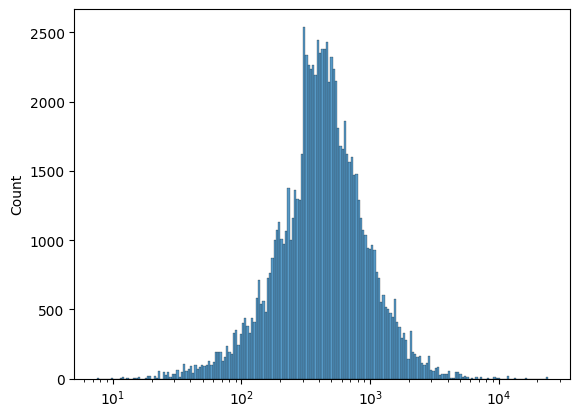

In [8]:
sns.histplot(graph.pt, log_scale=True)

In [74]:
old_samples_num_particles = [g.particle_id.unique().shape[0] for g in old_graphs]
new_samples_num_particles = [g.particle_id.unique().shape[0] for g in new_graphs]

In [75]:
old_samples_true_hits = [g.track_edges.unique().shape[0] for g in old_graphs]
new_samples_true_hits = [g.track_edges.unique().shape[0] for g in new_graphs]

In [76]:
old_samples_noise_hits = [g.x.shape[0] - g.track_edges.unique().shape[0] for g in old_graphs]
new_samples_noise_hits = [g.x.shape[0] - g.track_edges.unique().shape[0] for g in new_graphs]

In [77]:
old_samples_pt = [g.pt for g in old_graphs]
new_samples_pt = [g.pt for g in new_graphs]

In [78]:
old_samples_eta = [g.eta for g in old_graphs]
new_samples_eta = [g.eta for g in new_graphs]

Text(0.5, 1.0, 'Number of true edges per event')

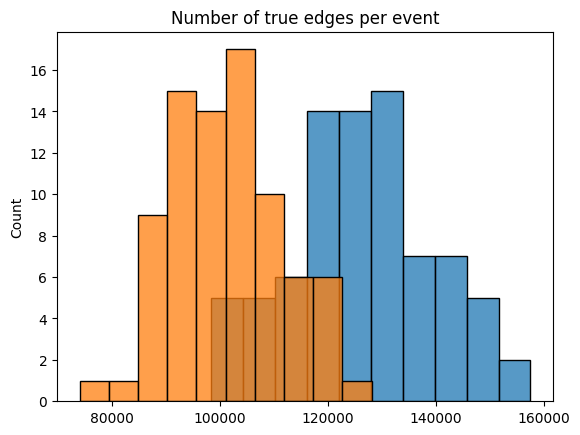

In [79]:
old_samples_mean_truth = [g.track_edges.shape[1] for g in old_graphs]
new_samples_mean_truth = [g.track_edges.shape[1] for g in new_graphs]
sns.histplot(old_samples_mean_truth, bins=10)
sns.histplot(new_samples_mean_truth, bins=10)
plt.title("Number of true edges per event")

Text(0.5, 1.0, 'Number of hits per track')

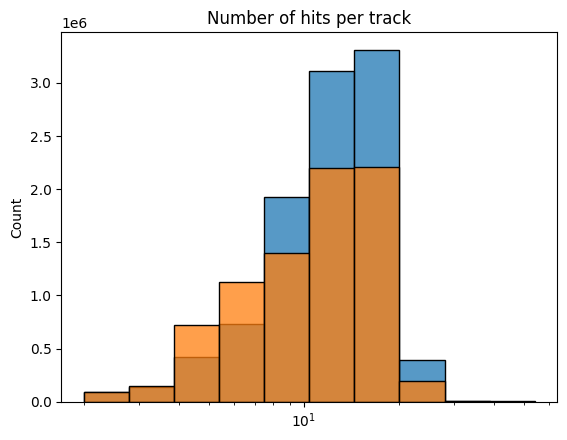

In [80]:
old_samples_track_lengths = [g.nhits for g in old_graphs]
new_samples_track_lengths = [g.nhits for g in new_graphs]
sns.histplot(torch.cat(old_samples_track_lengths), bins=10, log_scale=True)
sns.histplot(torch.cat(new_samples_track_lengths), bins=10, log_scale=True)
plt.title("Number of hits per track")

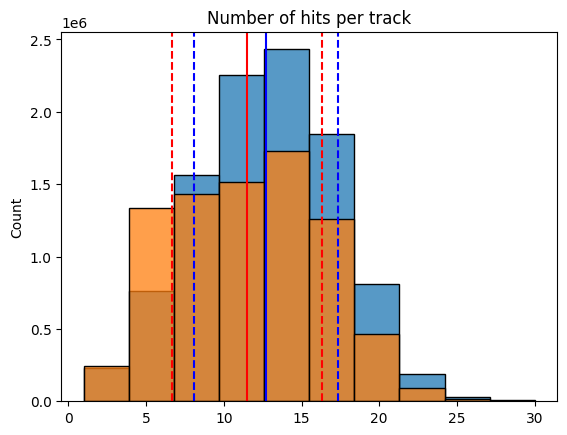

In [81]:
sns.histplot(torch.cat(old_samples_track_lengths), bins=10, binrange=[1, 30])
sns.histplot(torch.cat(new_samples_track_lengths), bins=10, binrange=[1, 30])
plt.title("Number of hits per track")
# add the mean and std
plt.axvline(torch.cat(old_samples_track_lengths).float().mean(), color="blue")
plt.axvline(torch.cat(new_samples_track_lengths).float().mean(), color="red")
plt.axvline(torch.cat(old_samples_track_lengths).float().mean() + torch.cat(old_samples_track_lengths).float().std(), color="blue", linestyle="--")
plt.axvline(torch.cat(new_samples_track_lengths).float().mean() + torch.cat(new_samples_track_lengths).float().std(), color="red", linestyle="--")
plt.axvline(torch.cat(old_samples_track_lengths).float().mean() - torch.cat(old_samples_track_lengths).float().std(), color="blue", linestyle="--")
plt.axvline(torch.cat(new_samples_track_lengths).float().mean() - torch.cat(new_samples_track_lengths).float().std(), color="red", linestyle="--")

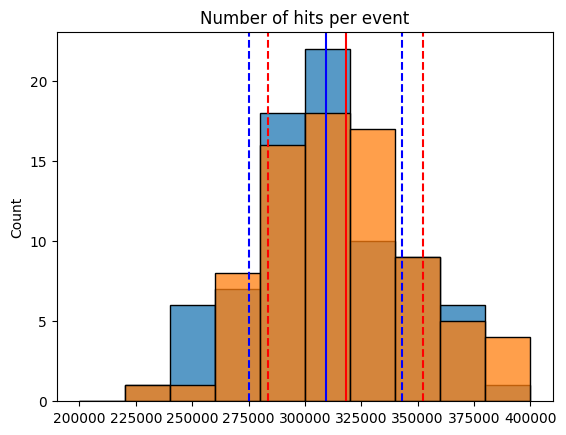

In [82]:
old_samples_event_size = [g.x.shape[0] for g in old_graphs]
new_samples_event_size = [g.x.shape[0] for g in new_graphs]
sns.histplot(old_samples_event_size, bins=10, binrange=[200000, 400000])
sns.histplot(new_samples_event_size, bins=10, binrange=[200000, 400000])
plt.title("Number of hits per event")
# add the mean and std
plt.axvline(np.mean(old_samples_event_size), color="blue")
plt.axvline(np.mean(new_samples_event_size), color="red")
plt.axvline(np.mean(old_samples_event_size) + np.std(old_samples_event_size), color="blue", linestyle="--")
plt.axvline(np.mean(new_samples_event_size) + np.std(new_samples_event_size), color="red", linestyle="--")
plt.axvline(np.mean(old_samples_event_size) - np.std(old_samples_event_size), color="blue", linestyle="--")
plt.axvline(np.mean(new_samples_event_size) - np.std(new_samples_event_size), color="red", linestyle="--")

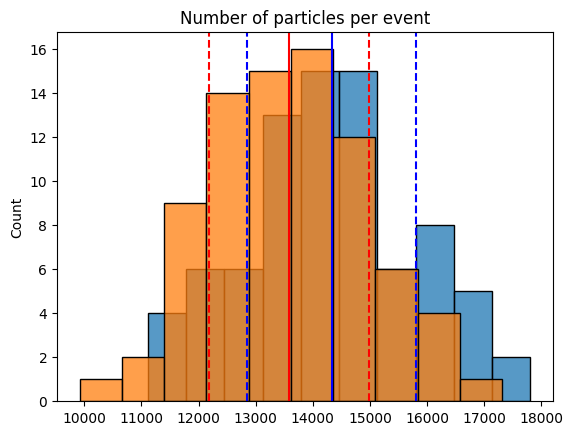

In [83]:
sns.histplot(old_samples_num_particles, bins=10)
sns.histplot(new_samples_num_particles, bins=10)
plt.title("Number of particles per event")
# add the mean and std
plt.axvline(np.mean(old_samples_num_particles), color="blue")
plt.axvline(np.mean(new_samples_num_particles), color="red")
plt.axvline(np.mean(old_samples_num_particles) + np.std(old_samples_num_particles), color="blue", linestyle="--")
plt.axvline(np.mean(new_samples_num_particles) + np.std(new_samples_num_particles), color="red", linestyle="--")
plt.axvline(np.mean(old_samples_num_particles) - np.std(old_samples_num_particles), color="blue", linestyle="--")
plt.axvline(np.mean(new_samples_num_particles) - np.std(new_samples_num_particles), color="red", linestyle="--")

Text(0.5, 0.8, 'new mean: 114034.77 +- 11667.52')

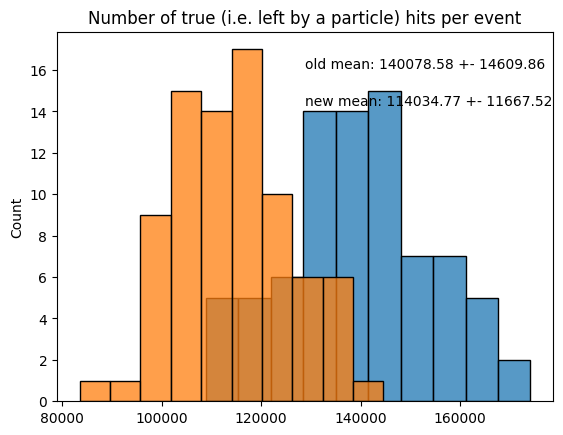

In [84]:
sns.histplot(old_samples_true_hits, bins=10)
sns.histplot(new_samples_true_hits, bins=10)
plt.title("Number of true (i.e. left by a particle) hits per event")
# add the mean and std in text
plt.text(0.5, 0.9, f"old mean: {np.mean(old_samples_true_hits):.2f} +- {np.std(old_samples_true_hits):.2f}", transform=plt.gca().transAxes)
plt.text(0.5, 0.8, f"new mean: {np.mean(new_samples_true_hits):.2f} +- {np.std(new_samples_true_hits):.2f}", transform=plt.gca().transAxes)

In [71]:
old_graphs[0].region

tensor([1., 1., 1.,  ..., 6., 6., 6.], dtype=torch.float64)

In [27]:
region = 1
print(torch.mean(torch.stack([(g.region[g.track_edges.unique()] == region).sum() for g in old_graphs]).float()), torch.mean(torch.stack([(g.region[g.track_edges.unique()] == region).sum() for g in new_graphs]).float()))

tensor(38667.1758) tensor(43775.4883)


In [28]:
region = 2
print(torch.mean(torch.stack([(g.region[g.track_edges.unique()] == region).sum() for g in old_graphs]).float()), torch.mean(torch.stack([(g.region[g.track_edges.unique()] == region).sum() for g in new_graphs]).float()))

tensor(6188.4375) tensor(0.)


In [6]:
sample_old = old_graphs[0]
sample_new = new_graphs[0]

In [33]:
(sample_old.region[sample_old.track_edges.unique()] == 2).sum()

tensor(6825)

In [37]:
sample_new.region[sample_new.track_edges.unique()]

tensor([1., 1., 1.,  ..., 5., 5., 5.], dtype=torch.float64)

In [38]:
sample_old

Data(hit_id=[346315], x=[346315], y=[346315], z=[346315], r=[346315], phi=[346315], eta=[346315], region=[346315], cluster_x_1=[346315], cluster_y_1=[346315], cluster_z_1=[346315], cluster_x_2=[346315], cluster_y_2=[346315], cluster_z_2=[346315], norm_x=[346315], norm_y=[346315], norm_z_1=[346315], eta_angle_1=[346315], phi_angle_1=[346315], eta_angle_2=[346315], phi_angle_2=[346315], norm_z_2=[346315], track_edges=[2, 141610], particle_id=[141610], pt=[141610], radius=[141610], primary=[141610], nhits=[141610], pdgId=[141610], config=[1], event_id='000000175')

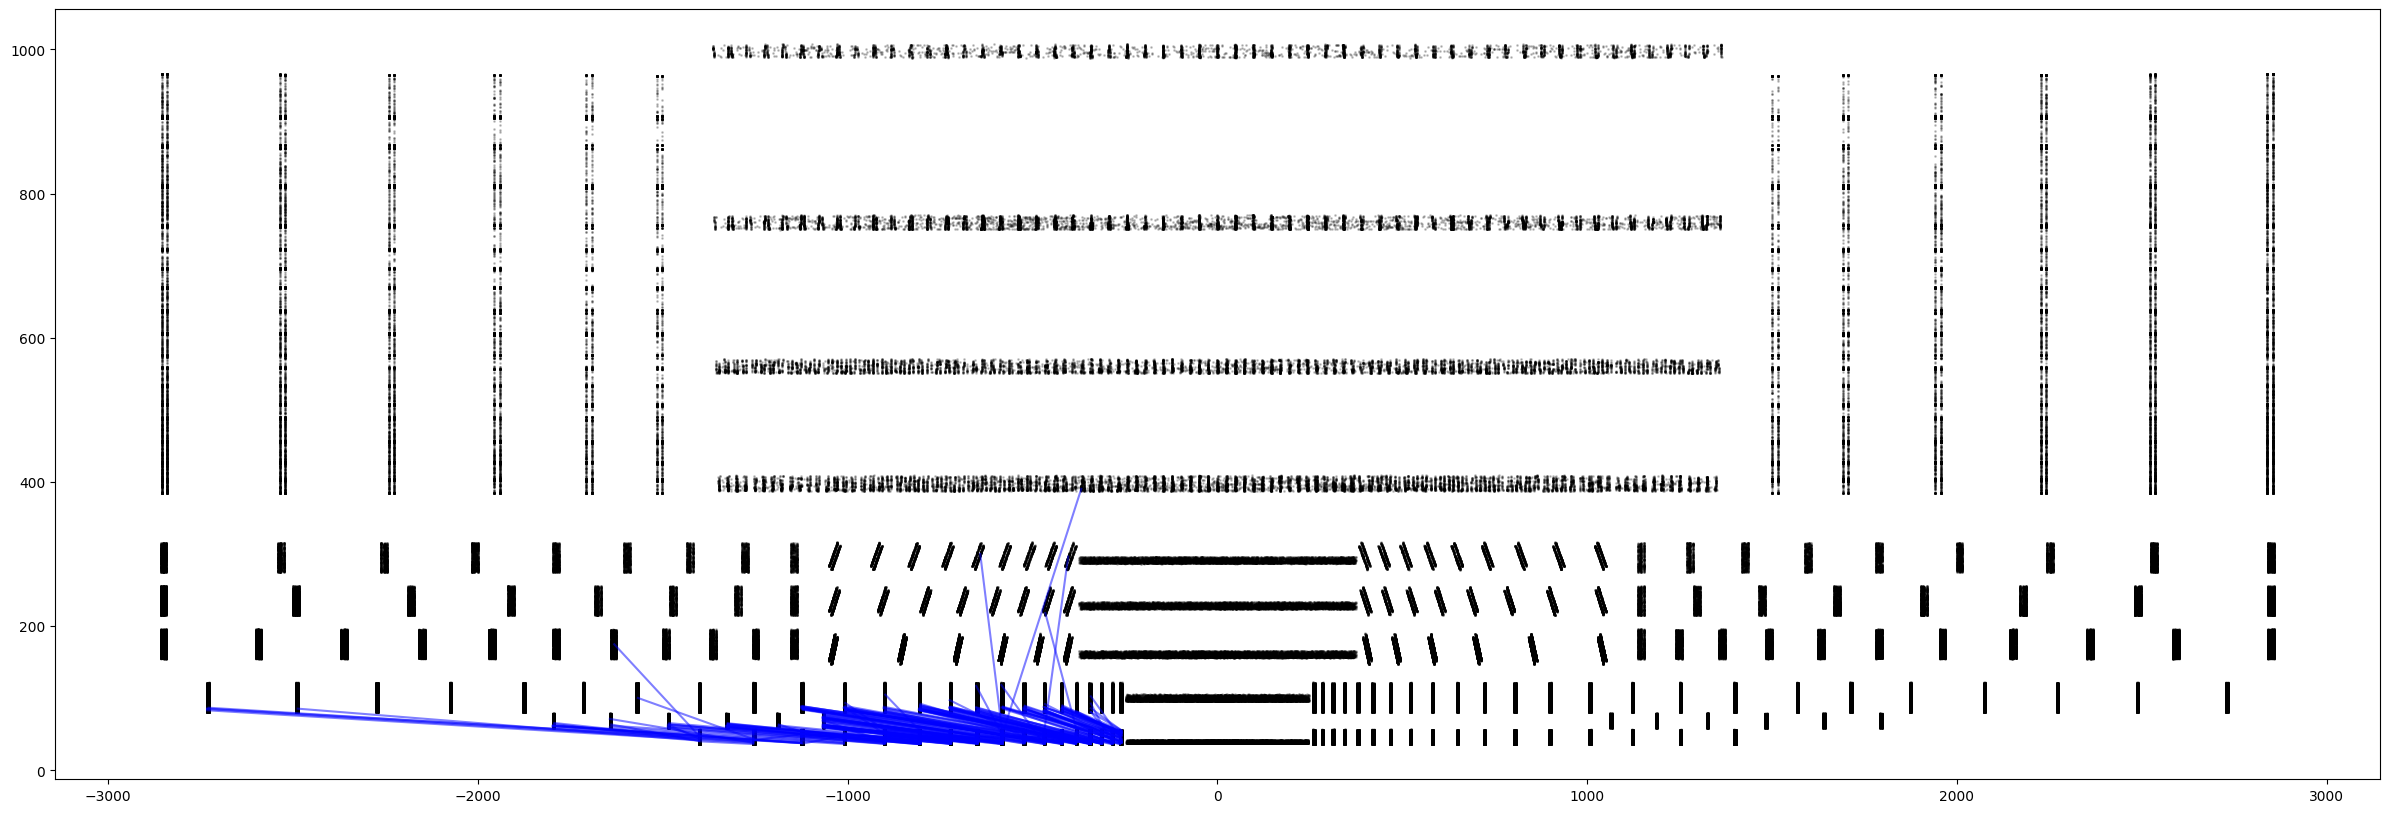

In [7]:
num_edges = 1000
plt.figure(figsize=(30, 10))
plt.scatter(sample_old.z, sample_old.r, s=1, c="k", alpha=0.2)
plt.plot(sample_old.z[sample_old.track_edges[:, :num_edges]], sample_old.r[sample_old.track_edges[:, :num_edges]], c="b", alpha=0.5);

In [8]:
sample_old

Data(hit_id=[326133], x=[326133], y=[326133], z=[326133], r=[326133], phi=[326133], eta=[326133], region=[326133], cluster_x_1=[326133], cluster_y_1=[326133], cluster_z_1=[326133], cluster_x_2=[326133], cluster_y_2=[326133], cluster_z_2=[326133], norm_x=[326133], norm_y=[326133], norm_z_1=[326133], eta_angle_1=[326133], phi_angle_1=[326133], eta_angle_2=[326133], phi_angle_2=[326133], norm_z_2=[326133], track_edges=[2, 133614], particle_id=[133614], pt=[133614], radius=[133614], primary=[133614], nhits=[133614], pdgId=[133614], config=[1], event_id='000000171')

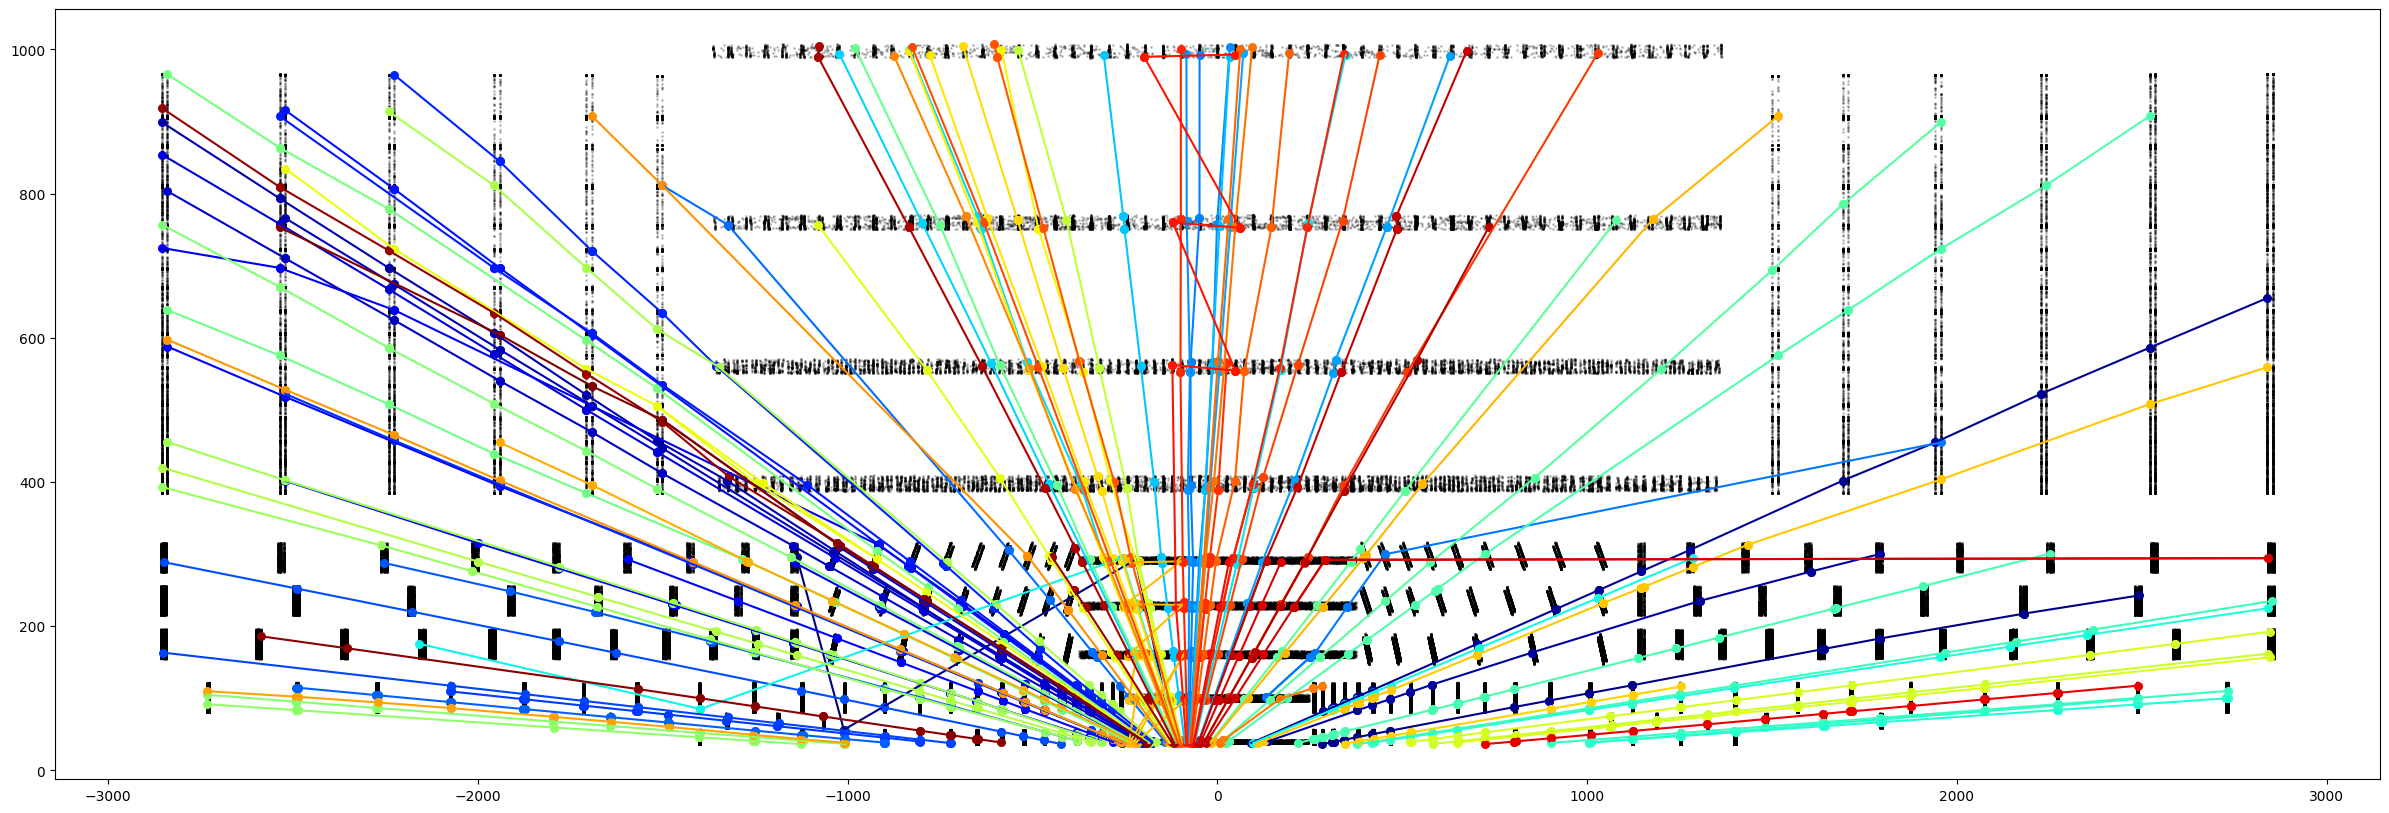

In [20]:
num_particles = 100
plt.figure(figsize=(30, 10))
plt.scatter(sample_old.z, sample_old.r, s=1, c="k", alpha=0.2)
colors = plt.cm.jet(np.linspace(0, 1, num_particles))
for i, pid in enumerate(sample_old.particle_id.unique()[:num_particles]):
    plt.plot(sample_old.z[sample_old.track_edges[:, sample_old.particle_id == pid]], sample_old.r[sample_old.track_edges[:, sample_old.particle_id == pid]], c=colors[i]);
    plt.scatter(sample_old.z[sample_old.track_edges[:, sample_old.particle_id == pid]], sample_old.r[sample_old.track_edges[:, sample_old.particle_id == pid]], s=30, color=colors[i]);

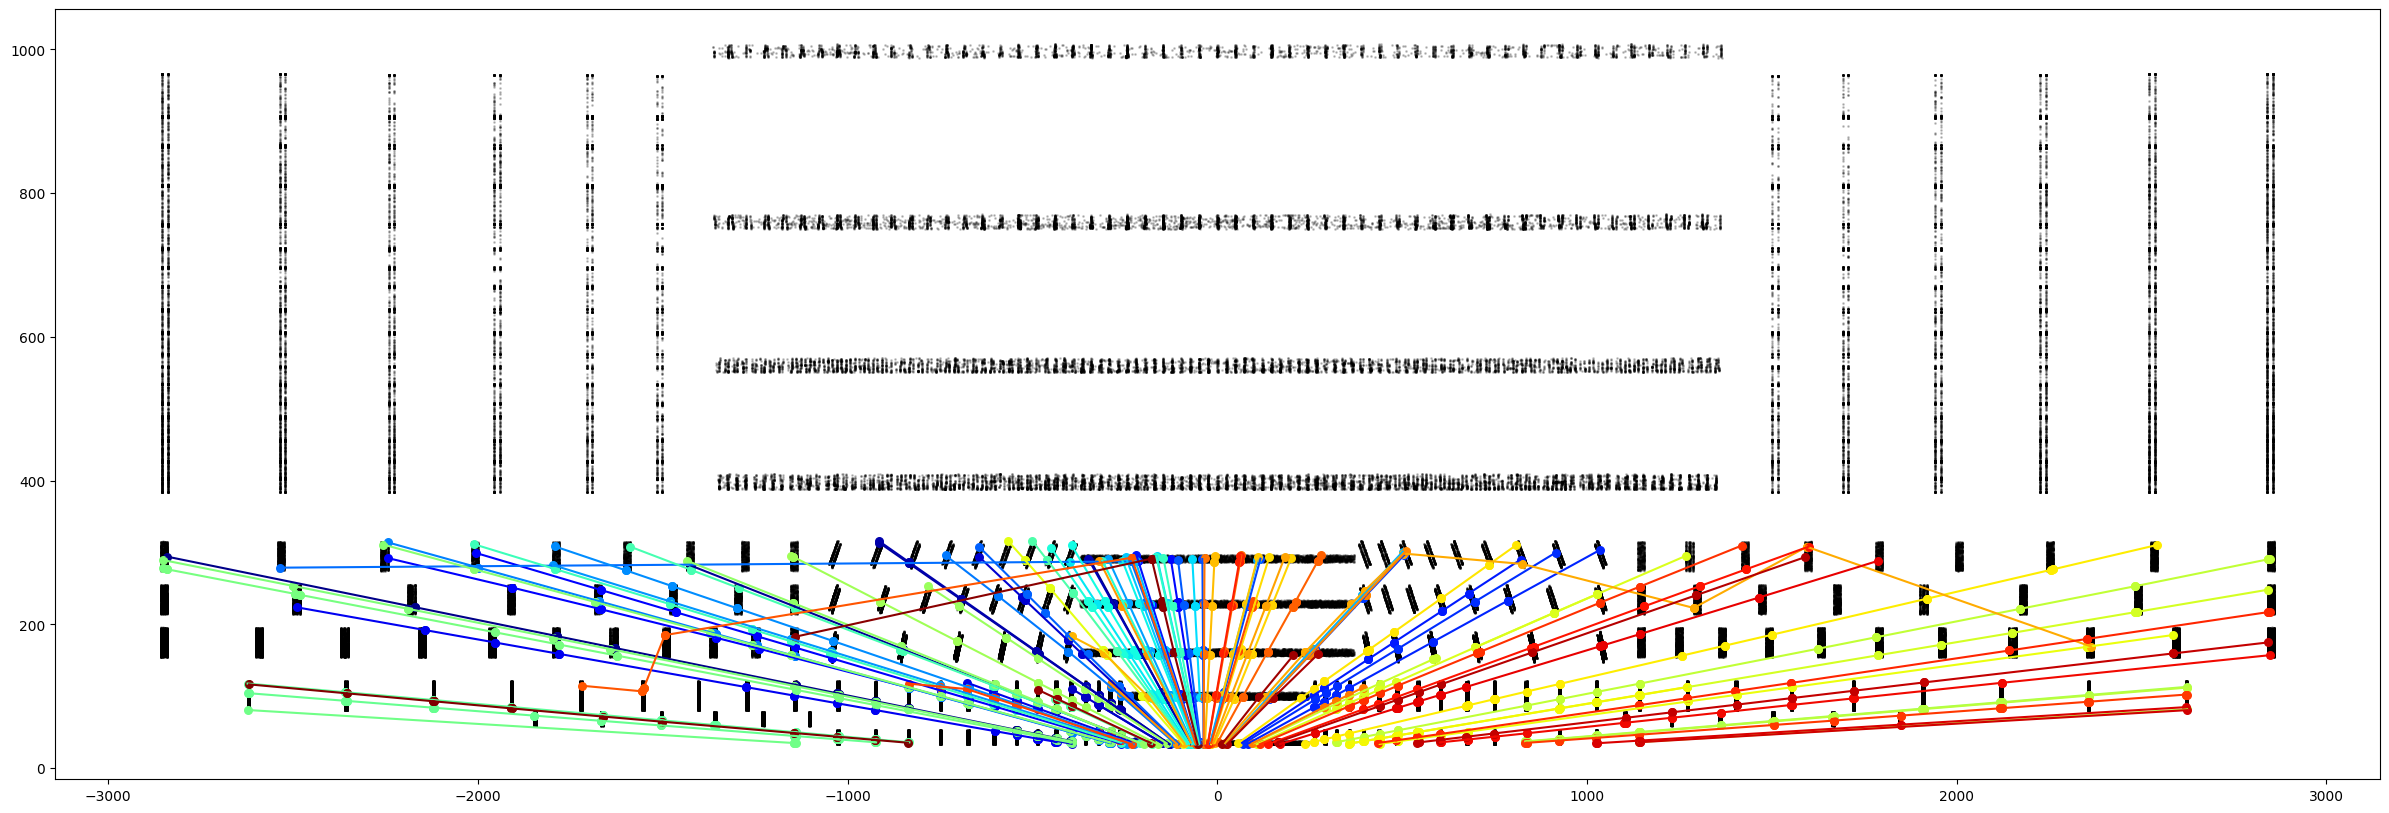

In [19]:
num_particles = 100
plt.figure(figsize=(30, 10))
plt.scatter(sample_new.z, sample_new.r, s=1, c="k", alpha=0.2)
colors = plt.cm.jet(np.linspace(0, 1, num_particles))
for i, pid in enumerate(sample_new.particle_id.unique()[:num_particles]):
    plt.plot(sample_new.z[sample_new.track_edges[:, sample_new.particle_id == pid]], sample_new.r[sample_new.track_edges[:, sample_new.particle_id == pid]], c=colors[i]);
    plt.scatter(sample_new.z[sample_new.track_edges[:, sample_new.particle_id == pid]], sample_new.r[sample_new.track_edges[:, sample_new.particle_id == pid]], s=30, color=colors[i]);

In [25]:
(sample_old.region == 2).sum()

tensor(20789)

In [26]:
(sample_new.region == 2).sum()

tensor(20254)

In [92]:
sample_old.region.unique(return_counts=True), sample_new.region.unique(return_counts=True)

((tensor([1., 2., 3., 4., 5., 6.], dtype=torch.float64),
  tensor([82567, 16954, 60780, 34895, 83190, 15972])),
 (tensor([1., 2., 3., 4., 5., 6.], dtype=torch.float64),
  tensor([81781, 14689, 32916, 31590, 80665, 13968])))

In [93]:
sample_old

Data(hit_id=[294358], x=[294358], y=[294358], z=[294358], r=[294358], phi=[294358], eta=[294358], region=[294358], cluster_x_1=[294358], cluster_y_1=[294358], cluster_z_1=[294358], cluster_x_2=[294358], cluster_y_2=[294358], cluster_z_2=[294358], norm_x=[294358], norm_y=[294358], norm_z_1=[294358], eta_angle_1=[294358], phi_angle_1=[294358], eta_angle_2=[294358], phi_angle_2=[294358], norm_z_2=[294358], track_edges=[2, 120633], particle_id=[120633], pt=[120633], radius=[120633], primary=[120633], nhits=[120633], pdgId=[120633], config=[1], event_id='000000112')

Text(0.5, 1.0, '2022 sample geometry')

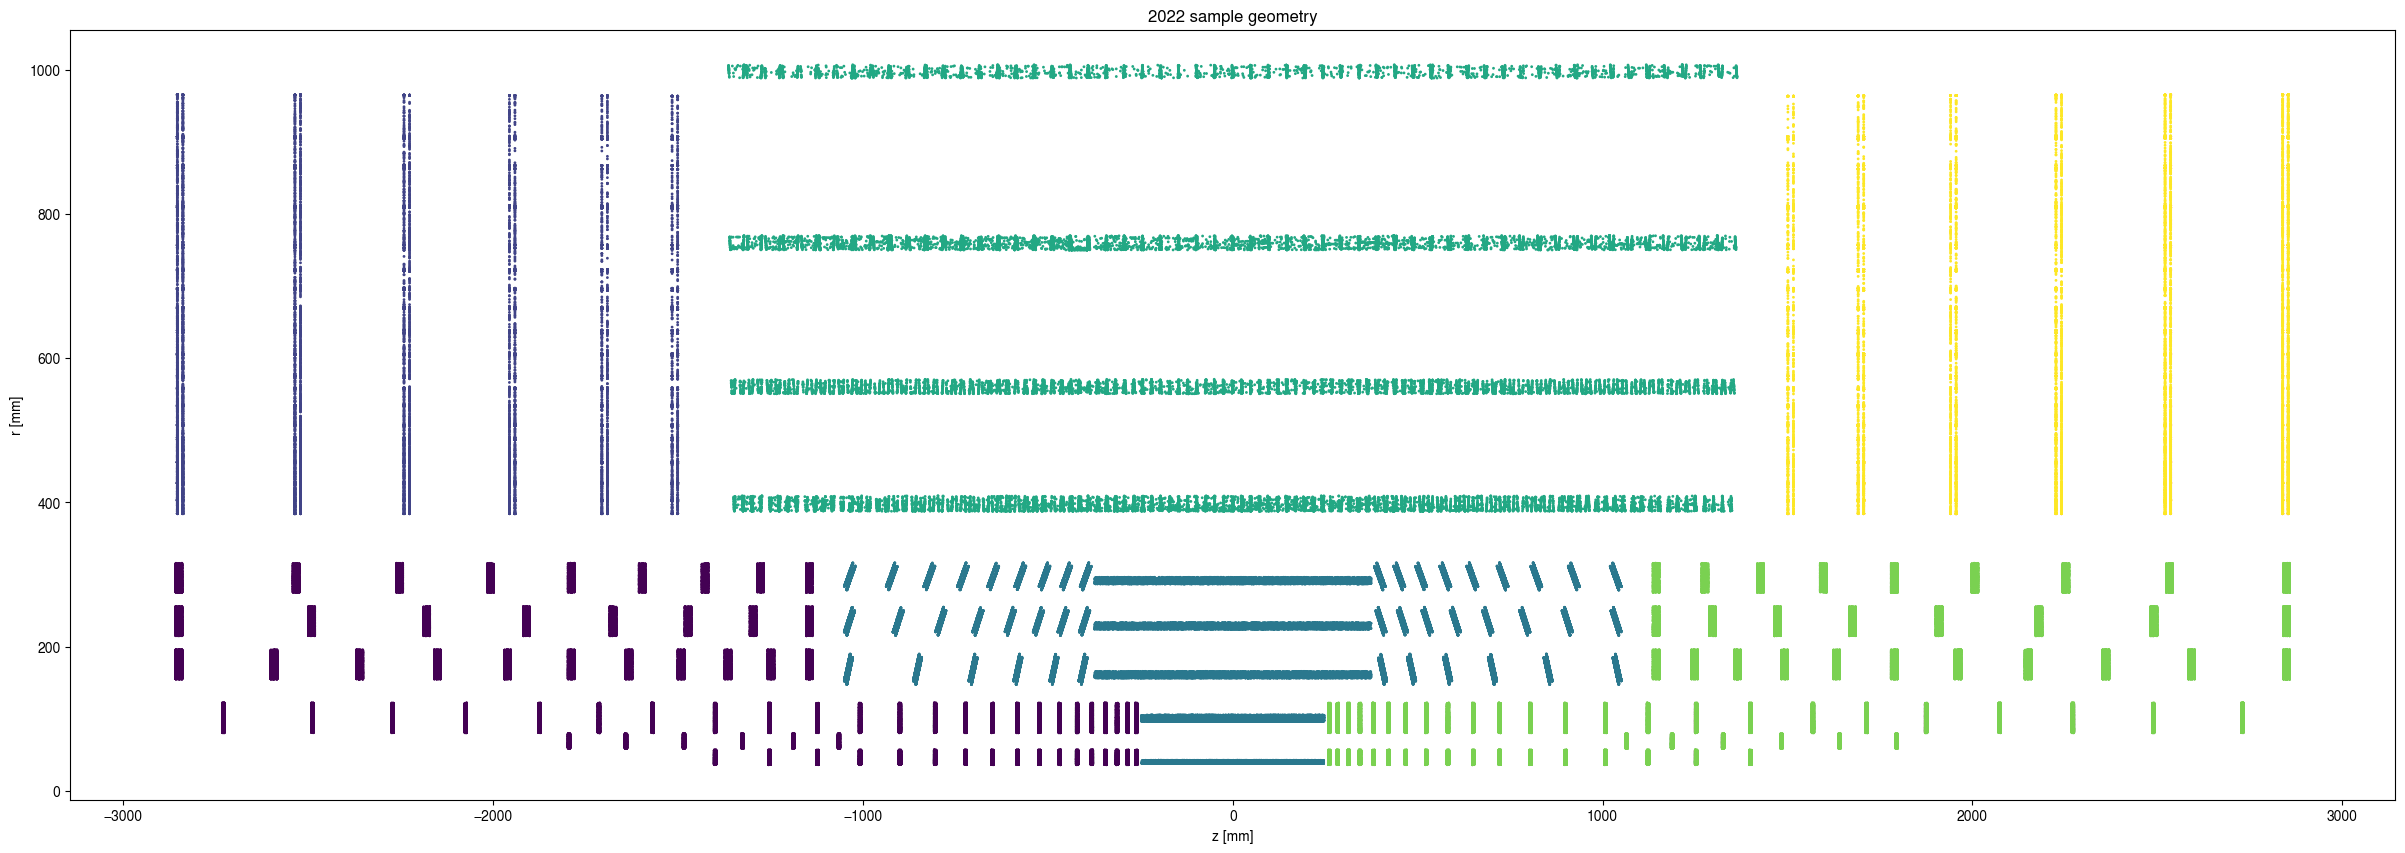

In [96]:
plt.figure(figsize=(30, 10))
plt.scatter(sample_old.z, sample_old.r, c=sample_old.region, s=1)

plt.xlabel("z [mm]")
plt.ylabel("r [mm]")
plt.title("2022 sample geometry")

Text(0.5, 1.0, '2023 sample geometry')

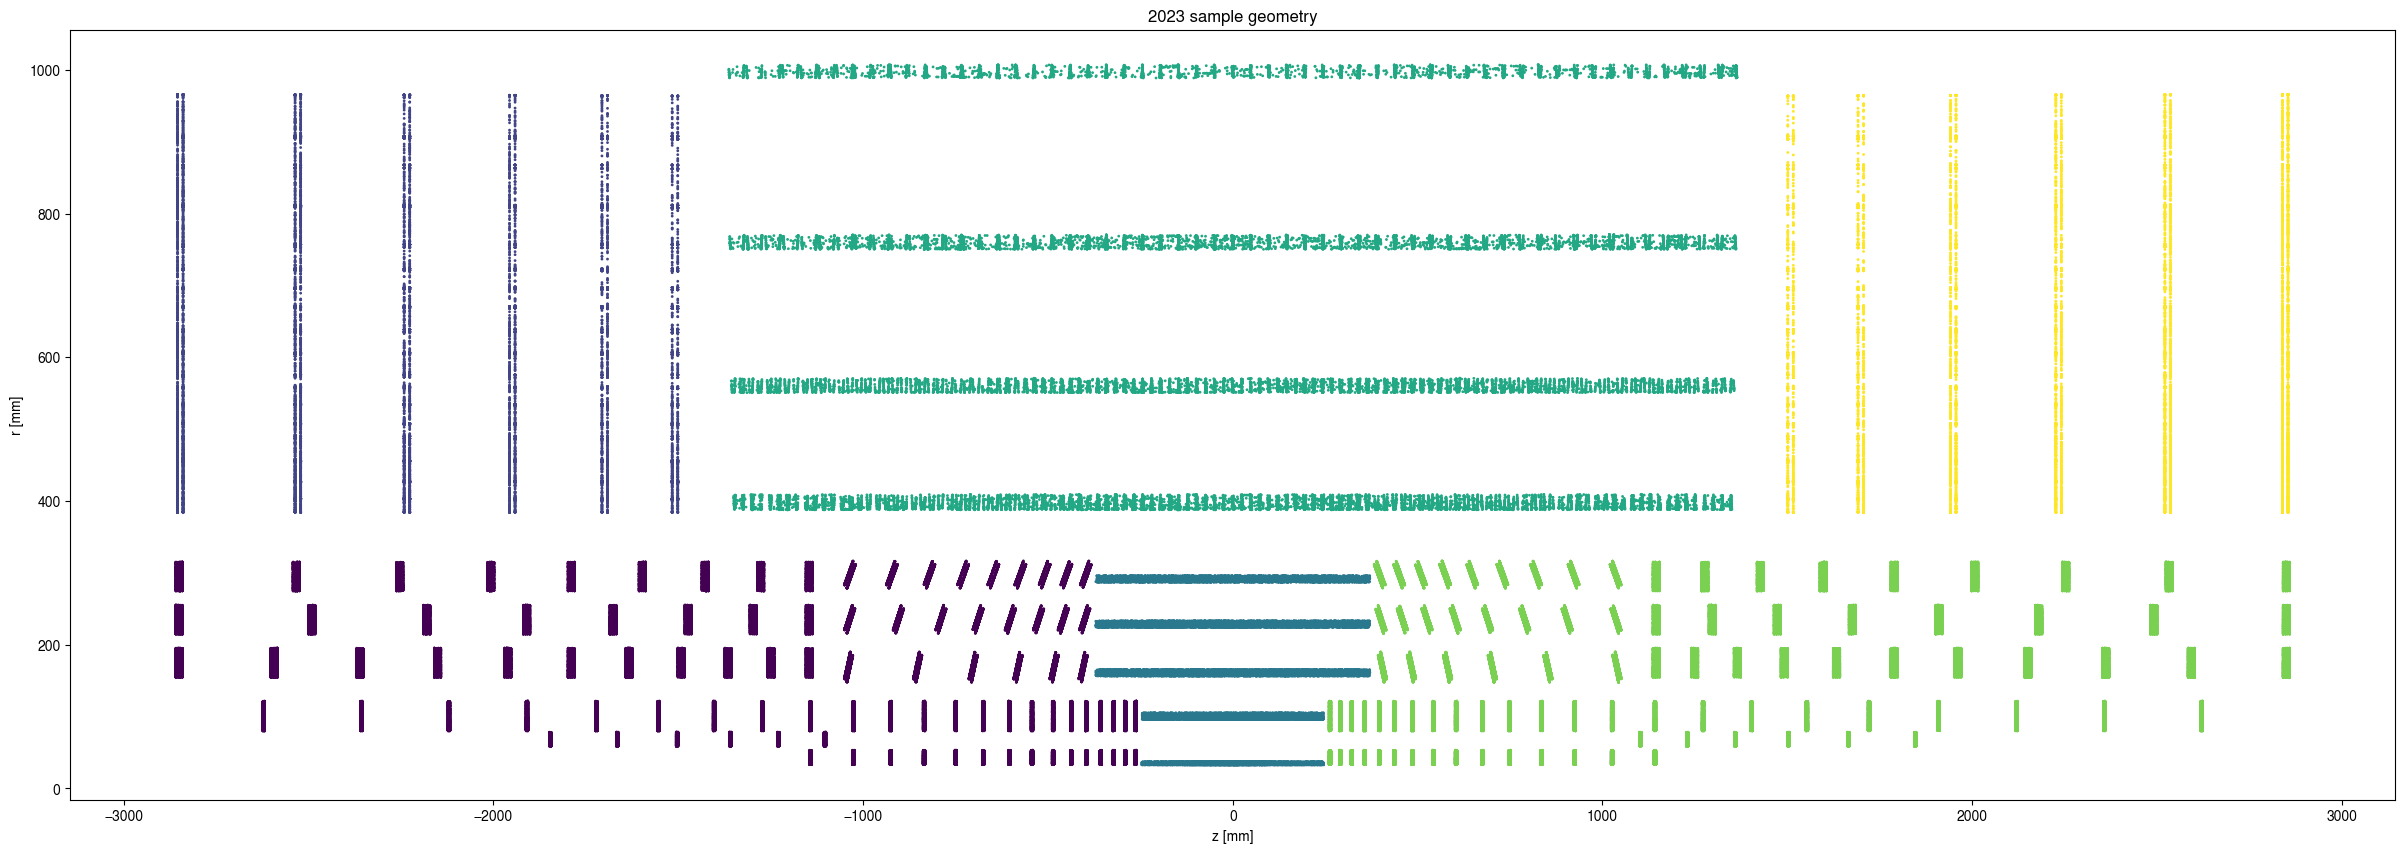

In [97]:
plt.figure(figsize=(30, 10))
plt.scatter(sample_new.z, sample_new.r, c=sample_new.region, s=1)

plt.xlabel("z [mm]")
plt.ylabel("r [mm]")
plt.title("2023 sample geometry")

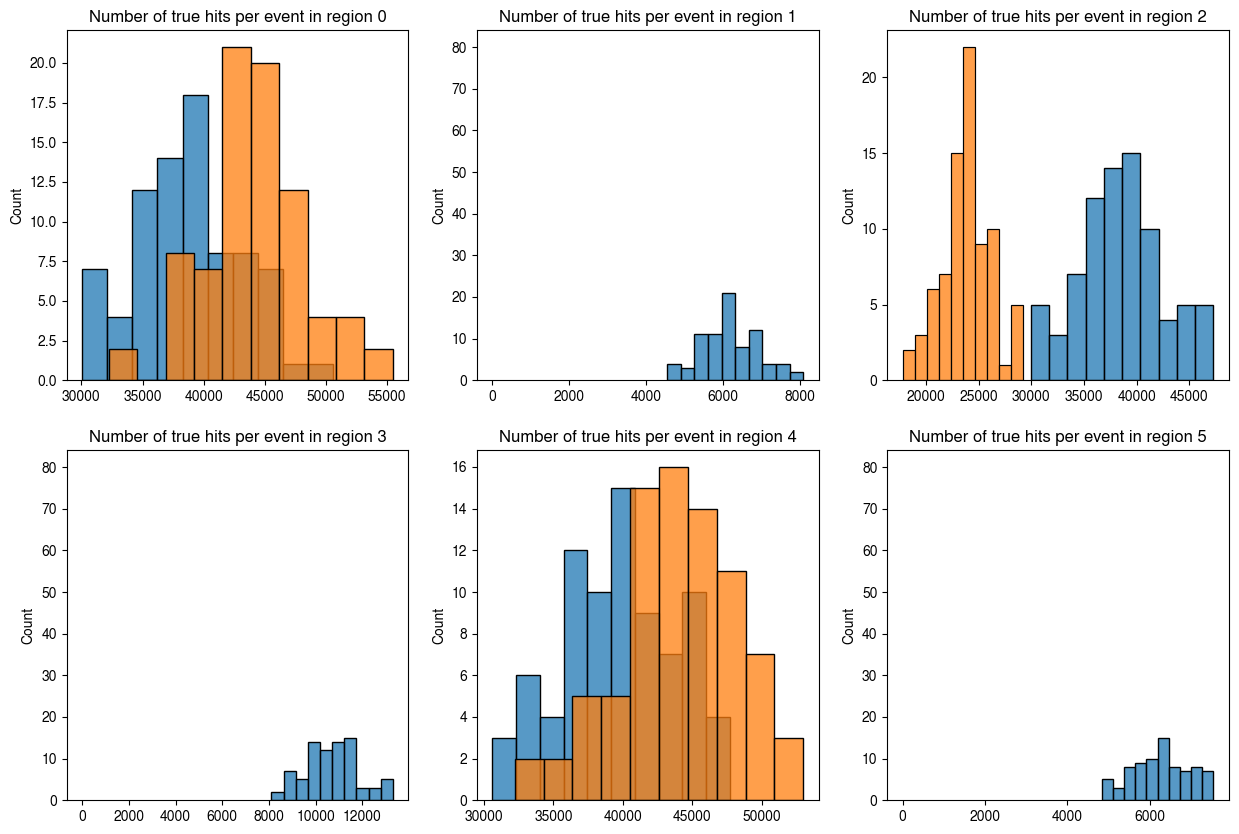

In [81]:
# Number of hits per region, there are 6 regions
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for region in range(6):
    sns.histplot(torch.stack([(g.region[g.track_edges.unique()] == region+1).sum() for g in old_graphs]), bins=10, ax= ax[region // 3, region % 3])
    sns.histplot(torch.stack([(g.region[g.track_edges.unique()] == region+1).sum() for g in new_graphs]), bins=10, ax= ax[region // 3, region % 3])
    ax[region // 3, region % 3].set_title(f"Number of true hits per event in region {region}")
    

Text(0.5, 0.8, 'new mean: 203983.30 +- 22988.57')

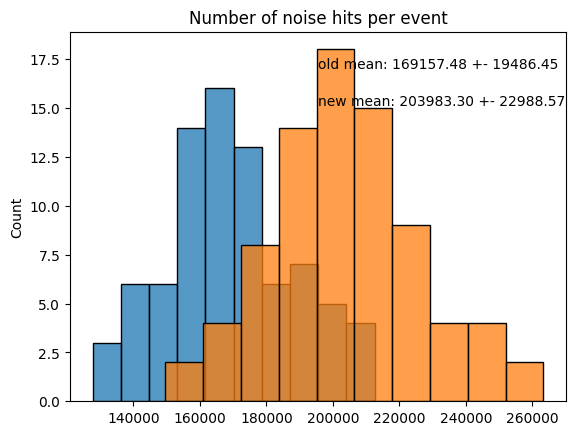

In [85]:
sns.histplot(old_samples_noise_hits, bins=10)
sns.histplot(new_samples_noise_hits, bins=10)
plt.title("Number of noise hits per event")
# add the mean and std in text
plt.text(0.5, 0.9, f"old mean: {np.mean(old_samples_noise_hits):.2f} +- {np.std(old_samples_noise_hits):.2f}", transform=plt.gca().transAxes)
plt.text(0.5, 0.8, f"new mean: {np.mean(new_samples_noise_hits):.2f} +- {np.std(new_samples_noise_hits):.2f}", transform=plt.gca().transAxes)

Text(0.5, 0.8, 'new mean: 573.46 +- 947.09')

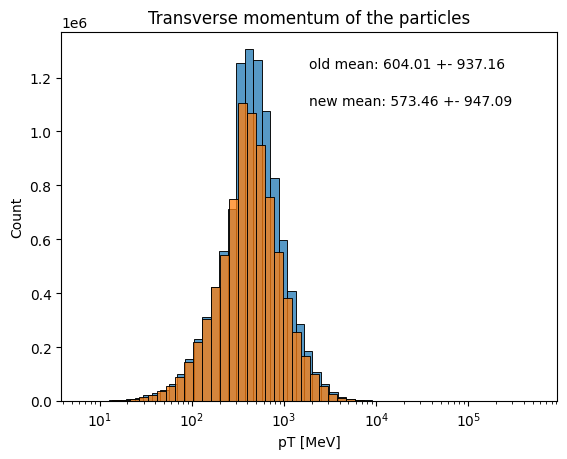

In [86]:
sns.histplot(torch.cat(old_samples_pt), bins=50, log_scale=True)
sns.histplot(torch.cat(new_samples_pt), bins=50, log_scale=True)
plt.title("Transverse momentum of the particles")
plt.xlabel("pT [MeV]")
# add the mean and std in text
plt.text(0.5, 0.9, f"old mean: {torch.cat(old_samples_pt).float().mean():.2f} +- {torch.cat(old_samples_pt).float().std():.2f}", transform=plt.gca().transAxes)
plt.text(0.5, 0.8, f"new mean: {torch.cat(new_samples_pt).float().mean():.2f} +- {torch.cat(new_samples_pt).float().std():.2f}", transform=plt.gca().transAxes)

Text(0.5, 1.0, 'Pseudorapidity of the hits')

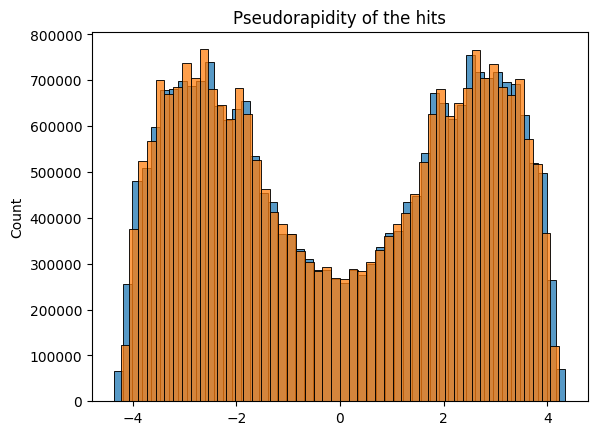

In [87]:
sns.histplot(torch.cat(old_samples_eta), bins=50)
sns.histplot(torch.cat(new_samples_eta), bins=50)
plt.title("Pseudorapidity of the hits")

In [69]:
sample

Data(hit_id=[296044], x=[296044], y=[296044], z=[296044], r=[296044], phi=[296044], eta=[296044], region=[296044], module_id=[296044], cluster_x_1=[296044], cluster_y_1=[296044], cluster_z_1=[296044], cluster_x_2=[296044], cluster_y_2=[296044], cluster_z_2=[296044], norm_x=[296044], norm_y=[296044], norm_z_1=[296044], eta_angle_1=[296044], phi_angle_1=[296044], eta_angle_2=[296044], phi_angle_2=[296044], norm_z_2=[296044], track_edges=[2, 120539], particle_id=[120539], pt=[120539], radius=[120539], primary=[120539], nhits=[120539], pdgId=[120539], config=[1], event_id='000000165')

## Study Raw Data

In [2]:
from gnn4itk_cf.stages.data_reading.models.athena_utils import read_particles

INFO:root:Wandb found, using WandbLogger


Old samples

In [12]:
input_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/FromCharline/ttbar/raw"
input_files = os.listdir(input_dir)
input_files = sorted([os.path.join(input_dir, f) for f in input_files])
input_particles_files = [f for f in input_files if "particles" in f]

In [4]:
num_particles_old = []
particles_eta_old = []
particles_pt_old = []
num_files = 100

for f in tqdm(input_particles_files[:num_files]):
    particles = read_particles(f)
    stable_particles = particles[particles["status"] == "1"]
    num_particles_old.append(len(stable_particles))
    particles_eta_old.append(stable_particles["eta"].values)
    particles_pt_old.append(stable_particles["pt"].values)

100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


New samples

In [5]:
input_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/jan_files/ITKEvents4Paper2023/NewITkSamples_ttbar_test1/J101_0"
input_files = os.listdir(input_dir)
input_files = sorted([os.path.join(input_dir, f) for f in input_files])
input_particles_files = [f for f in input_files if "particles" in f]

In [6]:
num_particles_new = []
particles_eta_new = []
particles_pt_new = []
num_files = 100

for f in tqdm(input_particles_files[:num_files]):
    particles = read_particles(f)
    stable_particles = particles[particles["status"] == "1"]
    num_particles_new.append(len(stable_particles))
    particles_eta_new.append(stable_particles["eta"].values)
    particles_pt_new.append(stable_particles["pt"].values)

100%|██████████| 100/100 [02:46<00:00,  1.67s/it]


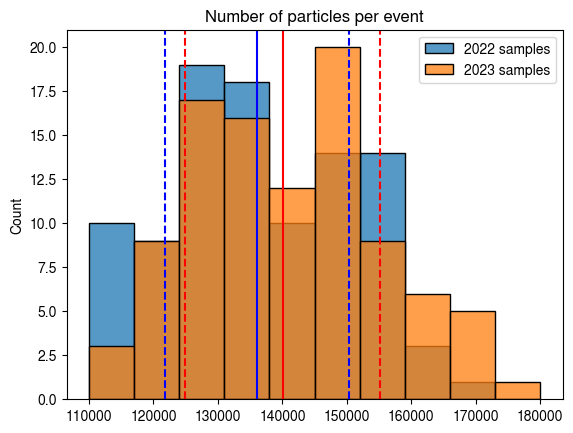

In [14]:
sns.histplot(num_particles_old, bins=10, binrange=[110000, 180000], label="2022 samples")
sns.histplot(num_particles_new, bins=10, binrange=[110000, 180000], label="2023 samples")
# add legend
plt.legend()
plt.title("Number of particles per event")
# add the mean and std
plt.axvline(np.mean(num_particles_old), color="blue")
plt.axvline(np.mean(num_particles_new), color="red")
plt.axvline(np.mean(num_particles_old) + np.std(num_particles_old), color="blue", linestyle="--")
plt.axvline(np.mean(num_particles_new) + np.std(num_particles_new), color="red", linestyle="--")
plt.axvline(np.mean(num_particles_old) - np.std(num_particles_old), color="blue", linestyle="--")
plt.axvline(np.mean(num_particles_new) - np.std(num_particles_new), color="red", linestyle="--")

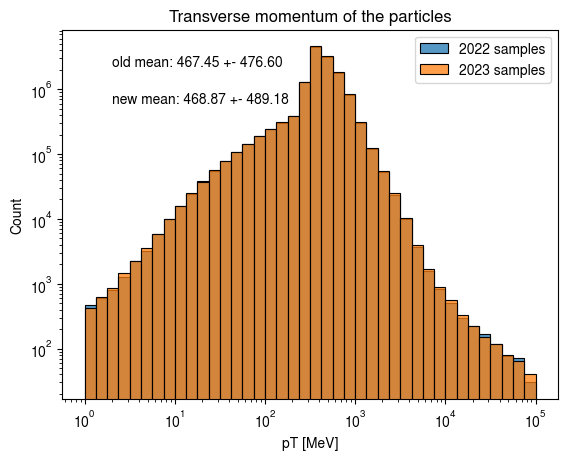

In [17]:
particles_pt_old = [np.array(p, dtype=np.float32) for p in particles_pt_old]
particles_pt_new = [np.array(p, dtype=np.float32) for p in particles_pt_new]
sns.histplot(np.concatenate(particles_pt_old), bins=40, binrange=(0, 5), log_scale=True, label="2022 samples")
sns.histplot(np.concatenate(particles_pt_new), bins=40, binrange=(0, 5), log_scale=True, label="2023 samples")
# add legend
plt.legend()
plt.title("Transverse momentum of the particles")
plt.xlabel("pT [MeV]")
# add the mean and std in text
plt.text(0.1, 0.9, f"old mean: {np.concatenate(particles_pt_old).mean():.2f} +- {np.concatenate(particles_pt_old).std():.2f}", transform=plt.gca().transAxes)
plt.text(0.1, 0.8, f"new mean: {np.concatenate(particles_pt_new).mean():.2f} +- {np.concatenate(particles_pt_new).std():.2f}", transform=plt.gca().transAxes)
# set y axis to log scale
plt.yscale("log")

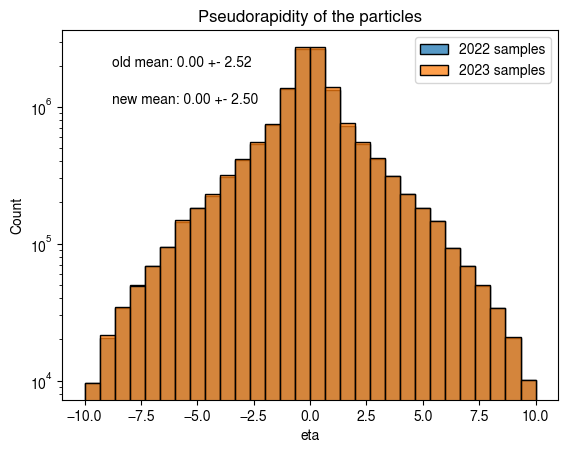

In [18]:
particles_eta_old = [np.array(p, dtype=np.float32) for p in particles_eta_old]
particles_eta_new = [np.array(p, dtype=np.float32) for p in particles_eta_new]
sns.histplot(np.concatenate(particles_eta_old), bins=30, binrange=(-10, 10), label="2022 samples")
sns.histplot(np.concatenate(particles_eta_new), bins=30, binrange=(-10, 10), label="2023 samples")
# add legend
plt.legend()
plt.title("Pseudorapidity of the particles")
plt.xlabel("eta")
# add the mean and std in text
plt.text(0.1, 0.9, f"old mean: {np.concatenate(particles_eta_old).mean():.2f} +- {np.concatenate(particles_eta_old).std():.2f}", transform=plt.gca().transAxes)
plt.text(0.1, 0.8, f"new mean: {np.concatenate(particles_eta_new).mean():.2f} +- {np.concatenate(particles_eta_new).std():.2f}", transform=plt.gca().transAxes)
plt.yscale("log")